Vanshika Shah, Zion Whitehall, George Diwan, Aarati Srikumar

# For our Project we create a new CSV by joining data from the sales_train and items csv in R
## Then we create a Linear Regressor Model in Python

## Importing necessary Libraries in Python

In [1]:
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics
import sys
#Uncommaent if need to install rpy2 package 
#!{sys.executable} -m pip install rpy2
import rpy2

%matplotlib inline
%load_ext rpy2.ipython

## Preprocessing in R to create the new csv which contains our target values

In [16]:
%%R
#install.packages(c("ggthemes", "Amelia", "caTools"))
library(readr)
library(data.table)
library(datasets)
library(dplyr)
library(lubridate)
library(ggplot2)
library(plotly)

In [17]:
%%R

#Read in training data files
dataset_sales_train = read.csv("sales_train.csv")
dataset_items = read.csv("items.csv")

In [18]:
%%R

dim(dataset_sales_train)
dim(dataset_items)
#Merge Dataset
dataset_sales <- dataset_sales_train %>% left_join(dataset_items, by = c("item_id"))
dataset_sales$item_name <- NULL
head(dataset_sales)

        date date_block_num shop_id item_id item_price item_cnt_day
1 02.01.2013              0      59   22154     999.00            1
2 03.01.2013              0      25    2552     899.00            1
3 05.01.2013              0      25    2552     899.00           -1
4 06.01.2013              0      25    2554    1709.05            1
5 15.01.2013              0      25    2555    1099.00            1
6 10.01.2013              0      25    2564     349.00            1
  item_category_id
1               37
2               58
3               58
4               58
5               56
6               59


In [19]:
%%R

#Clear variables
rm(dataset_sales_train)
rm(dataset_items)
dataset_sales <- as.data.frame(dataset_sales)
str(dataset_sales)

'data.frame':	2935849 obs. of  7 variables:
 $ date            : chr  "02.01.2013" "03.01.2013" "05.01.2013" "06.01.2013" ...
 $ date_block_num  : int  0 0 0 0 0 0 0 0 0 0 ...
 $ shop_id         : int  59 25 25 25 25 25 25 25 25 25 ...
 $ item_id         : int  22154 2552 2552 2554 2555 2564 2565 2572 2572 2573 ...
 $ item_price      : num  999 899 899 1709 1099 ...
 $ item_cnt_day    : num  1 1 -1 1 1 1 1 1 1 3 ...
 $ item_category_id: int  37 58 58 58 56 59 56 55 55 55 ...


In [20]:
%%R
#Create attributes
dataset_sales$date <- dmy(dataset_sales$date)
dataset_sales$year <- year(dataset_sales$date)
dataset_sales$month <- month(dataset_sales$date)
dataset_sales$day <- day(dataset_sales$date)
dataset_sales$weekday <- weekdays(dataset_sales$date)
dataset_sales$year <- as.factor(dataset_sales$year)
dataset_sales$weekday <- as.factor(dataset_sales$weekday)

In [21]:
%%R
dataset_sales_item_cnt_month <-
  dataset_sales %>% group_by(year, month, shop_id, item_id) %>% summarise(item_cnt_month = sum(item_cnt_day)) %>% ungroup()
dataset_sales <-
  dataset_sales %>% left_join(dataset_sales_item_cnt_month,
                              by = c("year", "month", "shop_id", "item_id"))
rm(dataset_sales_item_cnt_month)
head(dataset_sales)

`summarise()` has grouped output by 'year', 'month', 'shop_id'. You can override using the `.groups` argument.
        date date_block_num shop_id item_id item_price item_cnt_day
1 2013-01-02              0      59   22154     999.00            1
2 2013-01-03              0      25    2552     899.00            1
3 2013-01-05              0      25    2552     899.00           -1
4 2013-01-06              0      25    2554    1709.05            1
5 2013-01-15              0      25    2555    1099.00            1
6 2013-01-10              0      25    2564     349.00            1
  item_category_id year month day   weekday item_cnt_month
1               37 2013     1   2 Wednesday              1
2               58 2013     1   3  Thursday              0
3               58 2013     1   5  Saturday              0
4               58 2013     1   6    Sunday              1
5               56 2013     1  15   Tuesday              1
6               59 2013     1  10  Thursday              1


In [22]:
%%R
colSums(is.na(dataset_sales))
num.cols <- sapply(dataset_sales, is.numeric)
dataset_sales_numcols <- dataset_sales[, num.cols]
dataset_sales_numcols$date_block_num <- NULL
dataset_sales_numcols$month <- NULL
dataset_sales_numcols$day <- NULL
cor(dataset_sales_numcols)



                      shop_id     item_id   item_price item_cnt_day
shop_id           1.000000000  0.02939639 -0.024034051 -0.005229685
item_id           0.029396392  1.00000000 -0.134104042  0.016650304
item_price       -0.024034051 -0.13410404  1.000000000  0.011196625
item_cnt_day     -0.005229685  0.01665030  0.011196625  1.000000000
item_category_id  0.019380462  0.36943074 -0.253554162  0.014767919
item_cnt_month    0.002999427  0.06681713  0.002514264  0.435903895
                 item_category_id item_cnt_month
shop_id                0.01938046    0.002999427
item_id                0.36943074    0.066817127
item_price            -0.25355416    0.002514264
item_cnt_day           0.01476792    0.435903895
item_category_id       1.00000000    0.063476393
item_cnt_month         0.06347639    1.000000000


In [26]:
melted_corr <- melt(cor(dataset_sales_numcols))
ggplot(data = melted_corr, aes(x = Var1, y = Var2, fill = value)) + 
geom_tile() + 
scale_fill_gradient(low="grey", high="darkred") + 
geom_text(aes(x = Var1, y = Var2, label = round(value, 2)), size = 4) + 
labs(title = "Correlation Matrix", x = "Numeric Column(s)", y = "Numeric Column(s)", fill = "Coefficient Range") + 
theme(axis.text.x=element_text(angle=45, vjust=0.5))

rm(num.cols)
rm(dataset_sales_numcols)
rm(melted_corr)

SyntaxError: positional argument follows keyword argument (<ipython-input-26-d3ed9680877c>, line 2)

In [9]:
%%R
#Clear variables
rm(num.cols)
rm(dataset_sales_numcols)
rm(melted_corr)

#Saving our train data to the files
write.csv(dataset_sales, "enhanced_train_data.csv", row.names=TRUE)
rm(list=ls())

# Making the Linear Regression model in Python with all columns present

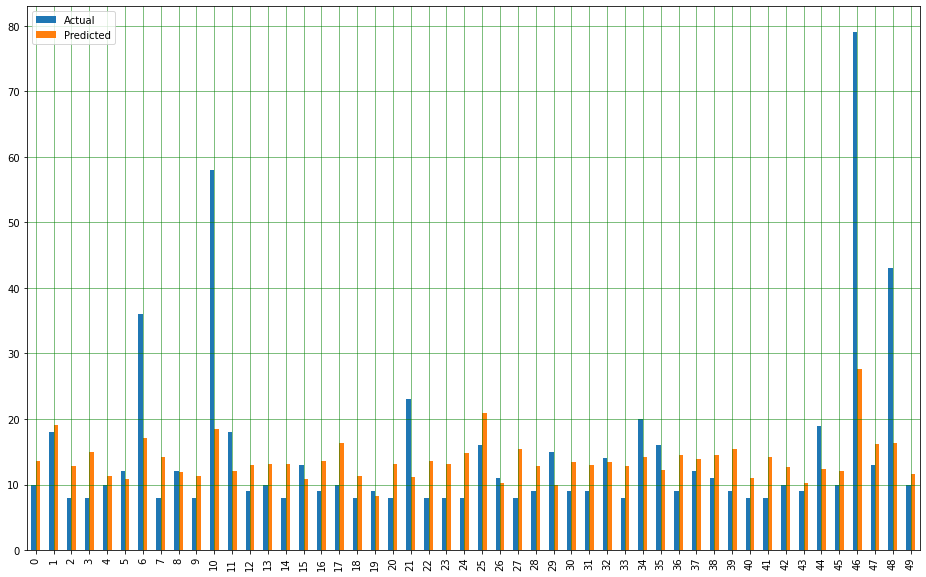

Mean Absolute Error: 6.442601062498102
Mean Squared Error: 324.0927493547014
Root Mean Squared Error: 18.00257618661011
R-squared Error: 0.31370409656815246


In [10]:
df = pd.read_csv('enhanced_train_data.csv')
nada = pd.Series(df.isnull().sum())
nada[nada != 0]

df = df.fillna(method='bfill')#change all NaN values
df = df.fillna(method='ffill')

from sklearn.preprocessing import OneHotEncoder


x=(list(df))
from sklearn.preprocessing import LabelEncoder
for col in x:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])

X = np.array(df.drop(['item_cnt_month'], 1)) #columns
y = np.array(df['item_cnt_month'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df3 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df1 = df3.head(50)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

In [11]:
print(df3.shape)
df3.describe()

(587170, 2)


,Actual,Predicted
count,587170.000000,587170.000000
mean,14.034087,13.995583
std,21.730981,11.956772
min,1.000000,-27.929818
25%,8.000000,11.262627
50%,9.000000,12.598259
75%,12.000000,14.143473
max,445.000000,1242.100879


In [12]:
df.head()

,Unnamed: 0,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,year,month,day,weekday,item_cnt_month
0,0,1,0,59,21791,11110,9,37,0,0,1,6,8
1,1,2,0,25,2495,10336,9,58,0,0,2,4,7
2,2,4,0,25,2495,10336,8,58,0,0,4,2,7
3,3,5,0,25,2497,14575,9,58,0,0,5,3,8
4,4,14,0,25,2498,11730,9,56,0,0,14,5,8


## Making the Linear Regression model with only columns that decrease the RMSE score and increase R-squared value

For data quality checking, and filling NA values, we used ffill to forward fill NA values, and bfill so that both NA values at the beginning and the end of the dataframe are accoutned for. We did not have any Nulls however.

We then used LabelEncoder to encode the levels of categorical features into numeric values.

When it came to feature selection, we tried many different approaches. At first we dropped all columns that contained NA values, and dropped columns with low variance. We then created new columns for new values, but these approaches did not lead to an increase in accuracy

Thus, I went through each column and found the ones that increased the accuracy. Specifically, I chose the columns that increased the R-sqaured value that evaluates the scatter of the data points around the fitted regression line. 
I also chose the columns that reduced the RMSE(root mean squared error) 

10
(2935849, 9)
(2935849,)


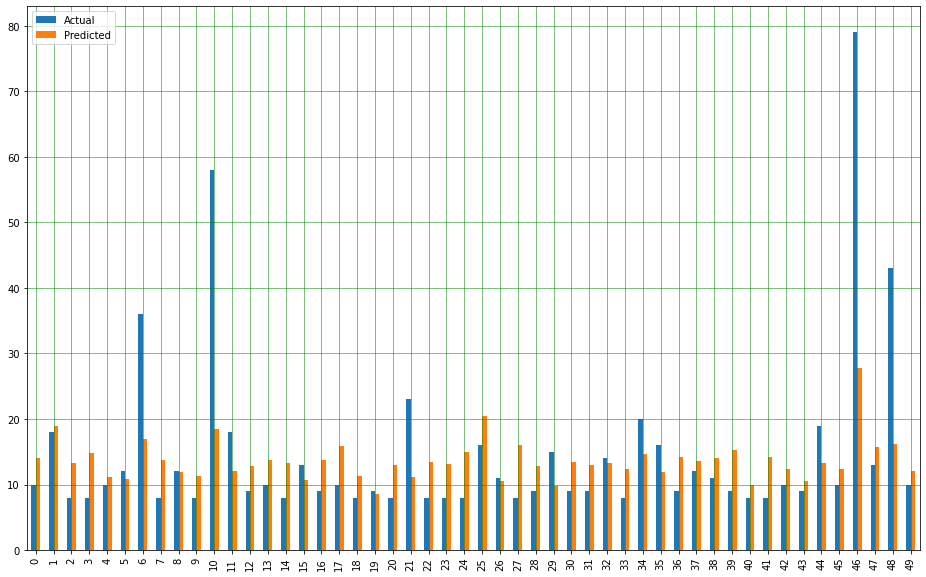

Mean Absolute Error: 6.448434294964893
Mean Squared Error: 324.2406933591303
Root Mean Squared Error: 18.00668468539199
R-squared Error: 0.31339081166937277


In [13]:
df = pd.read_csv('enhanced_train_data.csv')
cols = []
for i in range(2,len(df.columns)-2):
    cols.append(i)
df = df.drop(['Unnamed: 0'],axis =1)
# df = df.fillna(method='ffill')
# df = df.fillna(method='bfill')

cols = [0,2]
df.drop(df.columns[cols],axis=1,inplace=True)

x=(list(df))
from sklearn.preprocessing import LabelEncoder
for col in x:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(df)
print(len(df.columns))

X = np.array(df.drop(['item_cnt_month'], 1)) #columns
y = np.array(df['item_cnt_month'])
print(X.shape)
print(y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df3 = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})

df1 = df3.head(50)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))

In [14]:
print(df3.shape)
df3.describe()

(587170, 2)


,Actual,Predicted
count,587170.000000,587170.000000
mean,14.034087,13.996122
std,21.730981,11.951266
min,1.000000,-27.857216
25%,8.000000,11.275180
50%,9.000000,12.618318
75%,12.000000,14.111806
max,445.000000,1242.198353


## Using feature importance with Corr

Series([], dtype: int64)
Unnamed: 0          7.182677e+11
date                8.231132e+04
date_block_num      8.879270e+01
shop_id             2.633147e+02
item_id             3.872506e+07
item_price          2.629077e+07
item_cnt_day        3.242107e+00
item_category_id    2.924359e+02
year                5.905599e-01
month               1.250485e+01
day                 7.962855e+01
weekday             3.660207e+00
item_cnt_month      4.643873e+02
dtype: float64


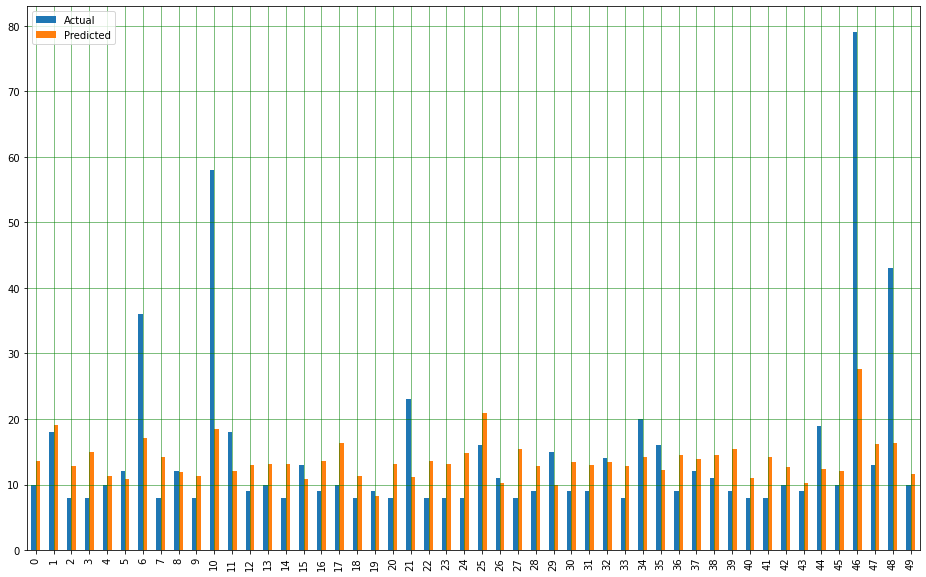

Mean Absolute Error: 6.442601062498102
Mean Squared Error: 324.0927493547014
Root Mean Squared Error: 18.00257618661011
R-squared Error: 0.31370409656815246


In [15]:
df = pd.read_csv('enhanced_train_data.csv')
nada = pd.Series(df.isnull().sum())
print(nada[nada != 0])
# df = df.drop(['Id'],axis =1)
# df = df.fillna(method='bfill')#change all NaN values
# df = df.fillna(method='ffill')

x=(list(df))
from sklearn.preprocessing import LabelEncoder
for col in x:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler() 
data_scaled = scaler.fit_transform(df)

corr = df.corr()
corr_values = {}
corrVal = []
i= 0

for col_name in corr.iloc[[11]]:
    corr_value = corr.iloc[11][i]
    corr_values[corr_value]=col_name
    corrVal.append(corr_value)
    i += 1
corrVal.sort(reverse=True)
corrVal=corrVal[0:11]

col_names =[]
for val in corrVal:
    col_names.append(corr_values[val])
df1 = df[col_names]
print(df.var())
X = np.array(df.drop(['item_cnt_month'], 1)) #columns
y = np.array(df['item_cnt_month'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()})
df1 = df.head(50)
df1.plot(kind='bar',figsize=(16,10))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R-squared Error:', metrics.r2_score(y_test, y_pred))